# Surgical Tool Segmentation: Model Inference



## 1. Environment Setup

In [10]:
# Folder location of the cloned or to-be-cloned repository
PROJECT_DIR = "Surgical-Segmentation-Challenge"

# --- COMMENT OUT IF RUNNING LOCALLY ---
# This section is for setting up the environment in Google Colab
%cd "/content"
repo_url = "https://github.com/isi22/Surgical-Segmentation-Challenge.git"
!git clone "{repo_url}" "{PROJECT_DIR}"
from google.colab import drive
drive.mount('/content/drive')
# --- END COMMENT OUT ---

# Change the current working directory to the project root
%cd "{PROJECT_DIR}"

# Install all required packages
print("\nInstalling dependencies from requirements.txt...")
!pip install -q -r requirements.txt

print("\n Environment setup complete. Current directory:")
!pwd

/content
fatal: destination path 'Surgical-Segmentation-Challenge' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/Surgical-Segmentation-Challenge

Installing dependencies from requirements.txt...

 Environment setup complete. Current directory:
/content/Surgical-Segmentation-Challenge


## 2. Configuration and Helper Functions

This section imports all necessary libraries and defines the key configuration parameters for the inference task, such as class names, image dimensions and file paths.

It also includes the definitions for the custom loss function (`combined_loss`), which is required to load the trained Keras model, and other helper functions defined during model training.


In [11]:
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence

In [12]:
IMG_ROWS, IMG_COLS = 480, 640
BATCH_SIZE = 8

# --- Path Definitions ---
DATA_DIR = 'data'
MODEL_DIR = 'models'
TEST_PATH = os.path.join(DATA_DIR, 'test_dataset')
MODEL_SAVE_PATH = os.path.join(MODEL_DIR, 'unet_efficientnetb4_best.keras')
HISTORY_SAVE_PATH = os.path.join(MODEL_DIR, 'live_training_history.csv')

# --- Model & Class Definitions ---
class_names = [
    "Background", "Tool clasper", "Tool wrist", "Tool shaft",
    "Suturing needle", "Thread", "Suction tool", "Needle holder",
    "Clamps", "Catheter"
]
NUM_CLASSES = len(class_names)

In [13]:
class SurgicalToolGenerator(Sequence):
    """Custom data generator"""
    def __init__(self, image_paths, mask_paths, batch_size, image_size, augment=False):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        if self.augment:
            self.augmentor = get_augmentation_pipeline()

    def __len__(self):
        """Number of batches per epoch."""
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        """Generates a batch of data."""
        batch_image_paths = self.image_paths[index*self.batch_size:(index+1)*self.batch_size]
        batch_mask_paths = self.mask_paths[index*self.batch_size:(index+1)*self.batch_size]

        batch_images = np.zeros((self.batch_size, self.image_size[0], self.image_size[1], 3), dtype=np.float32)
        batch_masks = np.zeros((self.batch_size, self.image_size[0], self.image_size[1]), dtype=np.uint8)

        for i, (img_path, mask_path) in enumerate(zip(batch_image_paths, batch_mask_paths)):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Resize
            img_resized = cv2.resize(img, (self.image_size[1], self.image_size[0]))
            mask_resized = cv2.resize(mask, (self.image_size[1], self.image_size[0]), interpolation=cv2.INTER_NEAREST)


            # Augment
            if self.augment:
                augmented = self.augmentor(image=img_resized, mask=mask_resized)
                img_resized = augmented['image']
                mask_resized = augmented['mask']

            # Normalise images
            batch_images[i] = img_resized / 255.0
            batch_masks[i] = mask_resized

        return batch_images, batch_masks

    def on_epoch_end(self):
        """Shuffle data at the end of every epoch."""
        if self.augment:
            combined = list(zip(self.image_paths, self.mask_paths))
            random.shuffle(combined)
            unzipped = list(zip(*combined))
            self.image_paths = list(unzipped[0])
            self.mask_paths = list(unzipped[1])

In [14]:
def get_paths(dataset_path):
    image_paths = sorted(glob.glob(os.path.join(dataset_path, 'all_rgb/*.png'), recursive=True))
    mask_paths = sorted(glob.glob(os.path.join(dataset_path, 'all_segmentation/*.png'), recursive=True))
    return image_paths, mask_paths

In [15]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    """Calculates the Dice loss, a measure of overlap between masks."""
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=NUM_CLASSES)
    y_pred_f = tf.cast(y_pred, tf.float32)

    # Flatten all dimensions except the class dimension
    y_true_f_flat = tf.keras.layers.Flatten()(y_true_one_hot)
    y_pred_f_flat = tf.keras.layers.Flatten()(y_pred)

    intersection = tf.reduce_sum(y_true_f_flat * y_pred_f_flat, axis=-1)
    union = tf.reduce_sum(y_true_f_flat, axis=-1) + tf.reduce_sum(y_pred_f_flat, axis=-1)

    dice_coeff = (2. * intersection + smooth) / (union + smooth)
    return 1.0 - dice_coeff

def combined_loss(y_true, y_pred):
    """Combines Sparse Categorical Cross-entropy and Dice Loss."""
    cross_entropy = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    cross_entropy_mean = tf.reduce_mean(cross_entropy, axis=[1, 2])
    dice = dice_loss(y_true, y_pred)
    return (0.5 * cross_entropy_mean) + (0.5 * dice)

## 3. Data Setup

### Download the Test Data, Training History and Trained Model

**When using Google Colab:**

When using Google Colab, the data needs to be re-downloaded every time a new virtual machine is used. The following cell automatically downloads the pre-processed data from the public Google Drive links.

In [16]:
# %%time

# # Create the data directory
# os.makedirs(DATA_DIR, exist_ok=True)

# if not os.path.exists(TEST_PATH):
#     print("Test data not found. Starting download and unzipping process...")

#     # Publicly shared Google Drive file IDs for the zip files
#     test_id = "1px81XhKGojwhSLVQTYUOeru5MWBoKzEO"

#     print("\nDownloading test.zip...")
#     !gdown --id {test_id} -O data/test_dataset.zip

#     # Unzip the files into the structured folders
#     print("\nUnzipping test data...")
#     !unzip -q data/test_dataset.zip -d {TEST_PATH}

#     # Clean up the zip files
#     !rm data/test_dataset.zip

#     print("\n Data download complete.")
# else:
#     print("Data already downloaded.")

In [17]:
%%time

# Create the data directories
os.makedirs(TEST_PATH, exist_ok=True)

if not os.path.exists(os.path.join(TEST_PATH, 'all_rgb')):
  print("\nCopying test_dataset.zip...")
  !cp "/content/drive/MyDrive/Colab Notebooks/Surgical_Tool_Segmentation/data/test_dataset.zip" "data/"

  #Unzip the files into the structured folders
  print("\nUnzipping data...")
  !unzip -q data/test_dataset.zip -d {TEST_PATH}

  # Clean up the zip files
  !rm data/test_dataset.zip

  print("\n Data copy complete.")
else:
    print("Data already copied.")

Data already copied.
CPU times: user 672 µs, sys: 0 ns, total: 672 µs
Wall time: 526 µs


In [18]:
%%time

# Create the data directory
os.makedirs(MODEL_DIR, exist_ok=True)

if not os.path.exists(MODEL_SAVE_PATH):
    print("Model not found. Starting download...")
    # Publicly shared Google Drive file IDs for the model
    model_id = "1xvKx3-jiATOshCrcar7AyfVzC72SmVfP"
    !gdown --id {model_id} -O {MODEL_SAVE_PATH}
    print("\n Model download complete.")
else:
    print("Model already downloaded.")

if not os.path.exists(HISTORY_SAVE_PATH):
    print("Training history not found. Starting download...")
    # Publicly shared Google Drive file IDs for the model
    history_id = "1R1Hs5hlAnHaGDcu4-S1X1fIIryuOU9Cm"
    !gdown --id {history_id} -O {HISTORY_SAVE_PATH}
    print("\n Training history download complete.")
else:
    print("Training history already downloaded.")

Model already downloaded.
Training history already downloaded.
CPU times: user 117 µs, sys: 16 µs, total: 133 µs
Wall time: 112 µs


**When running the notebook locally:**

1. **Create the `data` and `model` directories**

2. **Download the data:** download the test data, training history csv, and trained model

   - Test Set: https://drive.google.com/file/d/1px81XhKGojwhSLVQTYUOeru5MWBoKzEO/view?usp=drive_link

   - Training history: https://drive.google.com/file/d/1R1Hs5hlAnHaGDcu4-S1X1fIIryuOU9Cm/view?usp=drive_link

   - Trained model: https://drive.google.com/file/d/1xvKx3-jiATOshCrcar7AyfVzC72SmVfP/view?usp=drive_link

3. **Unzip the training data:** place the downloaded `training_dataset.zip` file inside the data folder and unzip it.

The final directory structure should look like this:

```
Surgical-Segmentation-Challenge/
└── data/
    └── test_dataset
        └── all_segmentation
        └── all_rgb
└── models/
    └── live_training_history.csv
    └── unet_efficientnetb4_best.keras
```

### Instantiate Test Generator

In [19]:
test_images, test_masks = get_paths(TEST_PATH)

test_generator = SurgicalToolGenerator(
    image_paths=test_images,
    mask_paths=test_masks,
    batch_size=BATCH_SIZE, # A batch size of 16 or 32 is fine for evaluation
    image_size=(IMG_ROWS, IMG_COLS),
    augment=False
)

## 4. Training Performance Evaluation

In [20]:
def plot_history_from_csv(filename):
    """
    Loads a training history from a CSV file and plots the results.
    """
    # Load the history from the CSV file
    history_df = pd.read_csv(filename)

    # Find the correct name for the MeanIoU metric key
    iou_metric_key = [key for key in history_df.columns if 'io_u' in key.lower() and 'val' not in key.lower()][0]
    val_iou_metric_key = 'val_' + iou_metric_key

    # --- Plot Loss ---
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_df['epoch'], history_df['loss'], label='Training Loss')
    plt.plot(history_df['epoch'], history_df['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # --- Plot Mean IoU ---
    plt.subplot(1, 2, 2)
    plt.plot(history_df['epoch'], history_df[iou_metric_key], label='Training Mean IoU')
    plt.plot(history_df['epoch'], history_df[val_iou_metric_key], label='Validation Mean IoU')
    plt.title('Mean IoU Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean IoU')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Plotting training history from the saved CSV file:


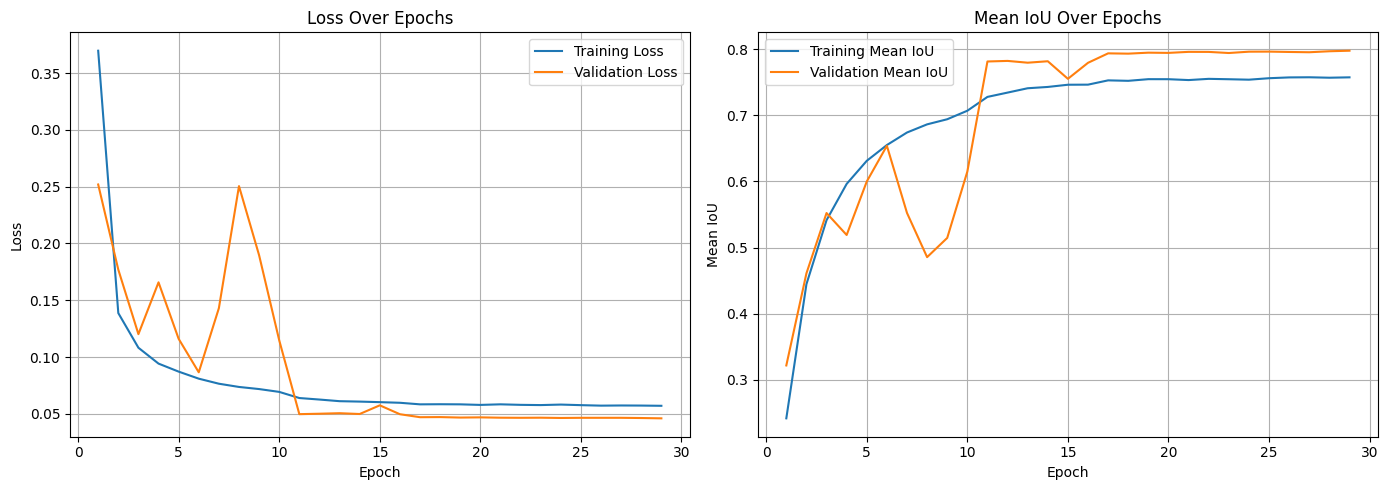

In [21]:
print("\nPlotting training history from the saved CSV file:")
plot_history_from_csv(HISTORY_SAVE_PATH)

## 5. Model Evaluation

This section evaluates the loaded model's performance on the unseen test set, providing both a quantitative score and qualitative visual examples.

Loading best saved model from: models/unet_efficientnetb4_best.keras

Evaluating model performance on the test set...
406/406 ━━━━━━━━━━━━━━━━━━━━ 219s 515ms/step - loss: 0.0752 - mean_io_u: 0.7043

--- FINAL MODEL PERFORMANCE ---
Test Loss: 0.0678
Test Mean IoU: 0.7439

Visualising predictions on a sample of the test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


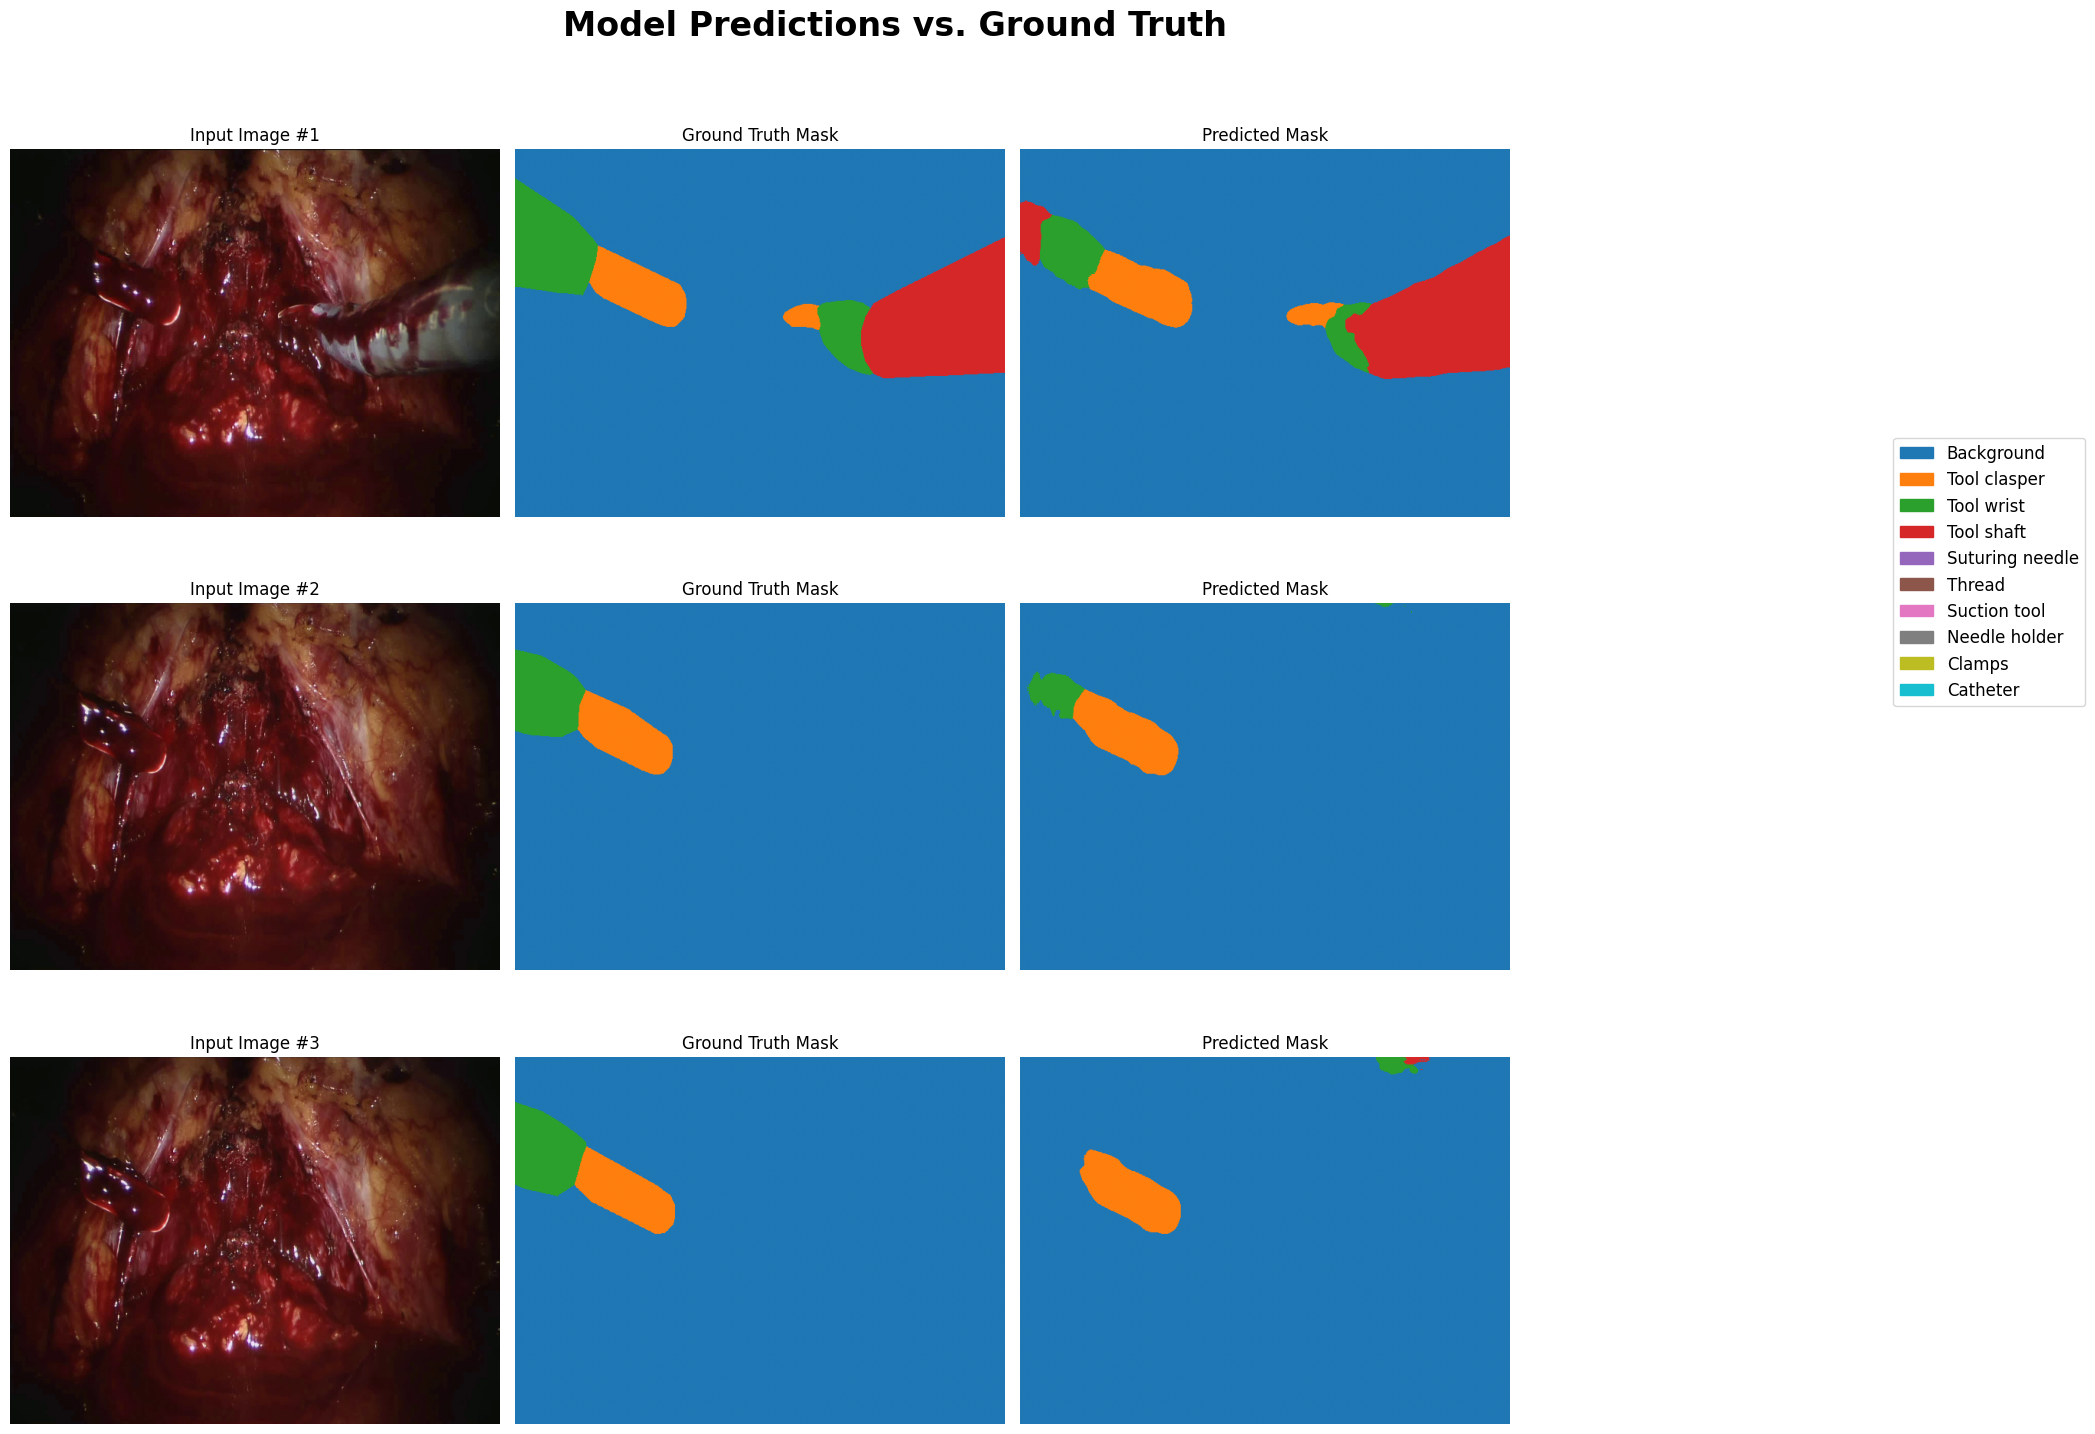

In [23]:
# --- Load the Best Saved Model ---
print(f"Loading best saved model from: {MODEL_SAVE_PATH}")

# We pass the custom loss function to the load_model call
best_model = load_model(MODEL_SAVE_PATH, custom_objects={'combined_loss': combined_loss})

# --- Evaluate on the Test Set ---
print("\nEvaluating model performance on the test set...")
test_loss, test_iou = best_model.evaluate(test_generator)
print(f"\n--- FINAL MODEL PERFORMANCE ---")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Mean IoU: {test_iou:.4f}")

# --- Visualise Predictions ---
def visualise_predictions(model, generator, num_examples=3):
    """Makes predictions and visualises them against the ground truth."""
    colours = plt.get_cmap('tab10', NUM_CLASSES)
    custom_cmap = mcolors.ListedColormap(colours.colors)
    fig, ax = plt.subplots(num_examples, 3, figsize=(18, 5 * num_examples))
    fig.suptitle('Model Predictions vs. Ground Truth', fontsize=24, fontweight='bold')

    # Get a single batch from the generator
    sample_image_batch, sample_mask_batch = generator[0] # Get the first batch

    # Make predictions
    pred_batch_prob = model.predict(sample_image_batch)
    pred_batch = np.argmax(pred_batch_prob, axis=-1)

    for i in range(num_examples):
        ax[i, 0].imshow(sample_image_batch[i])
        ax[i, 0].set_title(f'Input Image #{i+1}')

        ax[i, 1].imshow(sample_mask_batch[i], cmap=custom_cmap, vmin=0, vmax=NUM_CLASSES-1)
        ax[i, 1].set_title(f'Ground Truth Mask')

        ax[i, 2].imshow(pred_batch[i], cmap=custom_cmap, vmin=0, vmax=NUM_CLASSES-1)
        ax[i, 2].set_title(f'Predicted Mask')

    # Add a legend to the figure
    legend_patches = [mpatches.Patch(color=colours.colors[i], label=class_names[i]) for i in range(NUM_CLASSES)]
    fig.legend(handles=legend_patches, bbox_to_anchor=(1.05, 0.7), loc='upper left', fontsize=12)

    # Clean up the plot
    for axis in ax.flat:
        axis.axis('off')

    plt.tight_layout(rect=[0, 0, 0.85, 0.96]) # Adjust layout to make space for the legend
    plt.show()

print("\nVisualising predictions on a sample of the test set...")
visualise_predictions(best_model, test_generator)